In [1]:
from tensorflow.python.client import device_lib
devices=device_lib.list_local_devices()
def sizeof_fmt(num,suffix='B'):
    for unit in ['','Ki','Mi','Gi', 'Ti', 'Pi','Ei','Zi']:
        if abs(num)<1024.0:
            return "%3.1f %s%s" %(num, unit, suffix)
        num/=1024.0
    return "%.1f%s%s" %(num, 'Yi', suffix)
for d in devices:
    t=d.device_type
    name=d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len (x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  Quadro RTX 6000 || GPU || 21.3 GiB


In [2]:
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import top_k_categorical_accuracy
from scipy.ndimage import zoom
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
def CstmNet_2(input_shape=(128, 128, 64, 1)):

    X1_input = Input(input_shape)
    X2_input = Input(input_shape)
    
############ First input branch ######################

    X1 = Conv3D(32, (9, 9, 9), strides=1, name='conv3', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1_input)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(6, strides=6)(X1) 
    
    X1 = Conv3D(32, (6, 6, 6), strides=1, name='conv2', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(3, strides=3)(X1) 


    X1 = Conv3D(16, (3, 3, 3), strides=1, name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(3, strides=2)(X1)   
      
        
############ Second input branch ######################

    X2 = Conv3D(32, (9, 9, 9), strides=1, name='conv3_1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X2_input)
    X2 = BatchNormalization(axis=-1)(X2)
    X2 = Activation('relu')(X2)
    X2 = MaxPooling3D(6, strides=6)(X2) 
    
    X2 = Conv3D(32, (6, 6, 6), strides=1, name='conv2_1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X2)
    X2 = BatchNormalization(axis=-1)(X2)
    X2 = Activation('relu')(X2)
    X2 = MaxPooling3D(3, strides=3)(X2) 

    X2 = Conv3D(16, (3, 3, 3), strides=1, name='conv1_1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X2)
    X2 = BatchNormalization(axis=-1)(X2)
    X2 = Activation('relu')(X2)
    X2 = MaxPooling3D(3, strides=2)(X2)     

    
########## Concatenation layer to concatenate the two inputs prior to dense layers to calculate outputs ########
    final_concat = concatenate([X1, X2])

    X = Flatten()(final_concat)
    
############ Final Layer ######################
    
#     X = Dense(512, activation='relu', name='fc1', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = Dropout(0.1)(X)
    X = Dense(256, activation='relu', name='fc2', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(0.2)(X)
    X = Dense(128, activation='relu', name='fc3', kernel_initializer=glorot_uniform(seed=0))(X)
    drop = Dropout(0.2)(X)
    output = Dense(1, activation='sigmoid', name='fc5',kernel_initializer=glorot_uniform(seed=0))(drop) 
    model = Model(inputs=[X1_input, X2_input], outputs=output, name='CstmNet_2')
    
    return model

model = CstmNet_2(input_shape=(128, 128, 64, 1))
model.summary()

Model: "CstmNet_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 64 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 64 0                                            
__________________________________________________________________________________________________
conv3 (Conv3D)                  (None, 128, 128, 64, 23360       input_1[0][0]                    
__________________________________________________________________________________________________
conv3_1 (Conv3D)                (None, 128, 128, 64, 23360       input_2[0][0]                    
__________________________________________________________________________________________

In [4]:
import nibabel as nib
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image = nib.load(image_path)
            img = image.get_fdata()
            img = zoom(img, (0.533, 0.533, 0.413)) 
            img [img<0] = 0
            img_nor = img / np.max(img)
            img_nor = img_nor.astype(np.float32)
            
            img_data_array.append(img_nor)
            class_name.append(dir1)
    return img_data_array, class_name

## extract the image array and class name
img_train1, class_train1 =create_dataset(r'C:/Dhruba Research Drive/10 fold Binary classification/Class_edema/train')
img_test, class_test =create_dataset(r'C:/Dhruba Research Drive/10 fold Binary classification/Class_edema/test')

img_train2, class_train2 =create_dataset(r'C:/Dhruba Research Drive/10 fold Binary classification/Class_enh/train')
img_test2, class_test2 =create_dataset(r'C:/Dhruba Research Drive/10 fold Binary classification\\Class_enh/test')

####################################################################################################

target_dict1={k: v for v, k in enumerate(np.unique(class_train1))}
target_val1=  [target_dict1[class_train1[i]] for i in range(len(class_train1))]
print(target_dict1)

target_dict_test={k: v for v, k in enumerate(np.unique(class_test))}
target_val_test=  [target_dict_test[class_test[i]] for i in range(len(class_test))]
print(target_dict_test)

#######################################################################################################

target_dict2={k: v for v, k in enumerate(np.unique(class_train2))}
target_val2=  [target_dict1[class_train2[i]] for i in range(len(class_train2))]
print(target_dict2)

target_dict_test2={k: v for v, k in enumerate(np.unique(class_test2))}
target_val_test2=  [target_dict_test2[class_test2[i]] for i in range(len(class_test2))]
print(target_dict_test2)

#######################################################################################################
## F only tumor Shape
# For Training Set ##
x1=np.array(img_train1, np.float32)
y_train1=np.array(list(map(int,target_val1)), np.float32)
X_train1 = np.expand_dims(x1, axis=4)

## For Test Set ###
x_test=np.array(img_test, np.float32)
y_test=np.array(list(map(int,target_val_test)), np.float32)
X_test = np.expand_dims(x_test, axis=4)

## CE brain shape 
## For Training Set ##
x2=np.array(img_train2, np.float32)
y_train2=np.array(list(map(int,target_val2)), np.float32)
X_train2 = np.expand_dims(x2, axis=4)

## For Test Set ###
x_test2=np.array(img_test2, np.float32)
y_test2=np.array(list(map(int,target_val_test2)), np.float32)
X_test2 = np.expand_dims(x_test2, axis=4)


print("################ tumor only shapes #####################")

print(X_train1.shape)
print(y_train1.shape)

print(X_test.shape)
print(y_test.shape)

print("############## tumor only shapes ############################")

print(X_train2.shape)
print(y_train2.shape)

print(X_test2.shape)
print(y_test2.shape)

{'GBM': 0, 'Mets': 1}
{'GBM': 0, 'Mets': 1}
{'GBM': 0, 'Mets': 1}
{'GBM': 0, 'Mets': 1}
################ tumor only shapes #####################
(276, 128, 128, 64, 1)
(276,)
(31, 128, 128, 64, 1)
(31,)
############## tumor only shapes ############################
(276, 128, 128, 64, 1)
(276,)
(31, 128, 128, 64, 1)
(31,)


In [5]:
import scipy

def scaleit(image, factor, isseg=False):
    order = 0 if isseg == True else 3

    height, width, depth= image.shape
    zheight             = int(np.round(factor * height))
    zwidth              = int(np.round(factor * width))
    zdepth              = depth

    if factor < 1.0:
        newimg  = np.zeros_like(image)
        row     = (height - zheight) // 2
        col     = (width - zwidth) // 2
        layer   = (depth - zdepth) // 2
        newimg[row:row+zheight, col:col+zwidth, layer:layer+zdepth] = scipy.ndimage.interpolation.zoom(image, (float(factor), float(factor), 1.0), order=order, mode='nearest')[0:zheight, 0:zwidth, 0:zdepth]

        return newimg

    elif factor > 1.0:
        row     = (zheight - height) // 2
        col     = (zwidth - width) // 2
        layer   = (zdepth - depth) // 2

        newimg = scipy.ndimage.interpolation.zoom(image[row:row+zheight, col:col+zwidth, layer:layer+zdepth], (float(factor), float(factor), 1.0), order=order, mode='nearest')  
        
        extrah = (newimg.shape[0] - height) // 2
        extraw = (newimg.shape[1] - width) // 2
        extrad = (newimg.shape[2] - depth) // 2
        newimg = newimg[extrah:extrah+height, extraw:extraw+width, extrad:extrad+depth]

        return newimg

    else:
        return image
    
################################ CE  ######################################

img_aug_array=[]
class_aug_array = []
zoom = [0.9, 1.1]
for d in range (y_train1.shape[0]):
    for e in range (2):
            volume = scaleit(X_train1[d, :, :, :, 0], zoom[e], isseg=False)
            img_aug_array.append(volume)
            
            y_train_class = y_train1[d]
            class_aug_array.append(y_train_class)
        
X_train_aug1_2 = np.array(img_aug_array, np.float32)
X_train_aug1_2 = np.expand_dims(X_train_aug1_2, axis=4)
print(X_train_aug1_2.shape)

y_train_aug1_2 = np.array(class_aug_array, np.float32)
print(y_train_aug1_2.shape)

################################ T2  ######################################

img_aug_array=[]
class_aug_array = []
zoom = [0.9, 1.1]
for d in range (y_train2.shape[0]):
    for e in range (2):
            volume = scaleit(X_train2[d, :, :, :, 0], zoom[e], isseg=False)
            img_aug_array.append(volume)
            
            y_train_class = y_train2[d]
            class_aug_array.append(y_train_class)
        
X_train_aug2_2 = np.array(img_aug_array, np.float32)
X_train_aug2_2 = np.expand_dims(X_train_aug2_2, axis=4)
print(X_train_aug2_2.shape)

y_train_aug2_2 = np.array(class_aug_array, np.float32)
print(y_train_aug2_2.shape)

(552, 128, 128, 64, 1)
(552,)
(552, 128, 128, 64, 1)
(552,)


In [6]:
# np.arange(-15, 16, 5)

In [7]:
from scipy import ndimage
img_aug_array=[]
class_aug_array = []
angles = np.arange(-10, 11, 5)
for d in range (y_train1.shape[0]):
    for e in range (5):
            volume = ndimage.rotate(img_train1[d], angles[e], reshape=False)
            img_aug_array.append(volume)
            
            y_train_class = y_train1[d]
            class_aug_array.append(y_train_class)

X_train_aug2 = np.array(img_aug_array, np.float32)
X_train_aug2 = np.expand_dims(X_train_aug2, axis=4)
print(X_train_aug2.shape)

y_train_aug2 = np.array(class_aug_array, np.float32)
print(y_train_aug2.shape)

img_aug_array=[]
class_aug_array = []
angles = np.arange(-15, 16, 5)
for d in range (y_train2.shape[0]):
    for e in range (5):
            volume = ndimage.rotate(img_train2[d], angles[e], reshape=False)
            img_aug_array.append(volume)
            
            y_train_class = y_train2[d]
            class_aug_array.append(y_train_class)

X_train_aug2_1 = np.array(img_aug_array, np.float32)
X_train_aug2_1 = np.expand_dims(X_train_aug2_1, axis=4)
print(X_train_aug2_1.shape)

y_train_aug2_1 = np.array(class_aug_array, np.float32)
print(y_train_aug2_1.shape)

(1380, 128, 128, 64, 1)
(1380,)
(1380, 128, 128, 64, 1)
(1380,)


In [8]:
X_train_f1 = X_train_aug2[:, ::-1, :]
y_train_f1 = y_train_aug2

X_train_aug1 = np.concatenate((X_train_aug1_2, X_train_aug2, X_train_f1), axis=0)
print(X_train_aug1.shape)
y_train_aug1 = np.concatenate((y_train_aug1_2, y_train_aug2, y_train_f1), axis=0)
print(y_train_aug1.shape)

X_train_f2 = X_train_aug2_1[:, ::-1, :]
y_train_f2 = y_train_aug2_1

X_train_aug2 = np.concatenate((X_train_aug2_2, X_train_aug2_1, X_train_f2), axis=0)
print(X_train_aug2.shape)
y_train_aug2 = np.concatenate((y_train_aug2_2, y_train_aug2_1, y_train_f2), axis=0)
print(y_train_aug2.shape)

(3312, 128, 128, 64, 1)
(3312,)
(3312, 128, 128, 64, 1)
(3312,)


In [9]:
# y_train_enc1 = to_categorical(y_train_aug1)
# y_test_enc1 = to_categorical (y_test)
# y_val_enc1 = to_categorical (y_val)
# print(y_val)
# ############################################################
# y_train_enc2 = to_categorical(y_train_aug2)
# y_test_enc2 = to_categorical (y_test2)
# y_val_enc2 = to_categorical (y_val2)
# print(y_val2)
# # print(y_val_enc2)

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


filepath = 'fold10_2class.epoch{epoch:02d}-acc{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=False,
                             mode='max')
callbacks = [checkpoint] 

#for Adam optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=6e-4,
    decay_steps=10000,
    decay_rate=0.9)

optim = tf.keras.optimizers.Adam(learning_rate=1e-4)   # learning_rate=lr_schedule


model.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=[sensitivity, specificity, 'accuracy'])

results=model.fit(
          x=[X_train_aug1, X_train_aug2],
          y=[y_train_aug1],
          validation_data = ([X_test, X_test2], y_test),
          epochs = 8,
          batch_size = 16,
          callbacks=callbacks)

In [15]:
classification_model = load_model('fold10_2class.epoch04-acc0.87.hdf5', compile = False)

C:\Users\dhruba\.conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


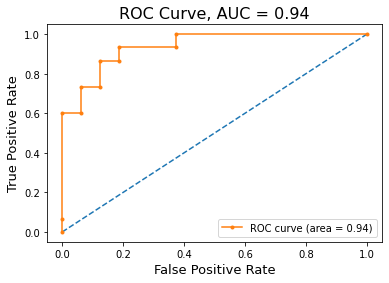

In [16]:
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y_test))]
y_pred = classification_model.predict(x=[X_test, X_test2], batch_size = 16)
lr_probs = y_pred

lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
#print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label="ROC curve (area = {0:0.2f})".format(lr_auc))
# axis labels
pyplot.xlabel('False Positive Rate', fontsize=13)
pyplot.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve, AUC = %.2f'%lr_auc, fontsize=16)
# show the legend
pyplot.legend()
plt.legend(loc="lower right")
# show the plot
pyplot.show()